# Preparing the Data

notes: the file paths are according to my laptop paths so change it to run and test

In [ ]:
!pip install tensorflow

In [51]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import os
import re
import plotly.express as px
import plotly.figure_factory as ff

from IPython.display import display
from PIL import Image
from tensorflow.keras.layers import Conv2D, LeakyReLU, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50


train_data = pd.read_csv('training.csv')
# train_data.info()

In [52]:
def sort_pattern(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split(r'(\d+)', s)]

def load_images(path):
    images = []
    file_list = os.listdir(path)
    sorted_file = sorted(file_list, key=sort_pattern)

    for filename in sorted_file:
        if filename.endswith(".jpg"):
            img_path = os.path.join(path, filename)
            img = Image.open(img_path).convert('L')
            images.append(np.array(img))  # Convert PIL Image to NumPy array
            img.close()

    return images

def show_keypoints(images, keypoints, n_rows=3, n_cols=7):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(2 * n_cols, 2 * n_rows), dpi=100)

    for i, ax in enumerate(axes.flatten()):
        img_array = np.array(images[i], dtype=np.uint8)  # Convert list of images to NumPy array
        img_array = img_array.squeeze()  # Remove singleton dimensions
        img = Image.fromarray(img_array)  # Convert NumPy array to PIL Image
        ax.imshow(img, cmap='gray')
        ax.set_title(f'Sample #{i}')

        for j in range(0, len(keypoints[i]), 2):
            x = keypoints[i][j]
            y = keypoints[i][j + 1]
            ax.plot(x, y, 'ro', markersize=2)

    plt.tight_layout()
    plt.show()

In [55]:
# For missing training data
print(f'Train sample: {len(train_data)}')

print('Percentage of missing values:')
train_data.isna().mean().round(4) * 100

Train sample: 7049
Percentage of missing values:


left_eye_center_x            0.0
left_eye_center_y            0.0
right_eye_center_x           0.0
right_eye_center_y           0.0
left_eye_inner_corner_x      0.0
left_eye_inner_corner_y      0.0
left_eye_outer_corner_x      0.0
left_eye_outer_corner_y      0.0
right_eye_inner_corner_x     0.0
right_eye_inner_corner_y     0.0
right_eye_outer_corner_x     0.0
right_eye_outer_corner_y     0.0
left_eyebrow_inner_end_x     0.0
left_eyebrow_inner_end_y     0.0
left_eyebrow_outer_end_x     0.0
left_eyebrow_outer_end_y     0.0
right_eyebrow_inner_end_x    0.0
right_eyebrow_inner_end_y    0.0
right_eyebrow_outer_end_x    0.0
right_eyebrow_outer_end_y    0.0
nose_tip_x                   0.0
nose_tip_y                   0.0
mouth_left_corner_x          0.0
mouth_left_corner_y          0.0
mouth_right_corner_x         0.0
mouth_right_corner_y         0.0
mouth_center_top_lip_x       0.0
mouth_center_top_lip_y       0.0
mouth_center_bottom_lip_x    0.0
mouth_center_bottom_lip_y    0.0
dtype: flo

In [56]:
train_data.fillna(train_data.describe().T['50%'], inplace=True)
train_data.sample(5).T

,3394,4985,2614,3584,3662
left_eye_center_x,70.538909,68.414491,66.121782,67.029433,66.105343
left_eye_center_y,36.073642,38.569304,38.769164,41.939498,38.042829
right_eye_center_x,28.179946,33.503366,28.340364,30.447293,30.113229
right_eye_center_y,35.615712,32.148878,40.868145,36.497526,34.151743
left_eye_inner_corner_x,59.304615,59.304615,59.304615,59.304615,59.304615
left_eye_inner_corner_y,37.878040,37.878040,37.878040,37.878040,37.878040
left_eye_outer_corner_x,73.247824,73.247824,73.247824,73.247824,73.247824
left_eye_outer_corner_y,37.639015,37.639015,37.639015,37.639015,37.639015
right_eye_inner_corner_x,36.651562,36.651562,36.651562,36.651562,36.651562
right_eye_inner_corner_y,37.944075,37.944075,37.944075,37.944075,37.944075


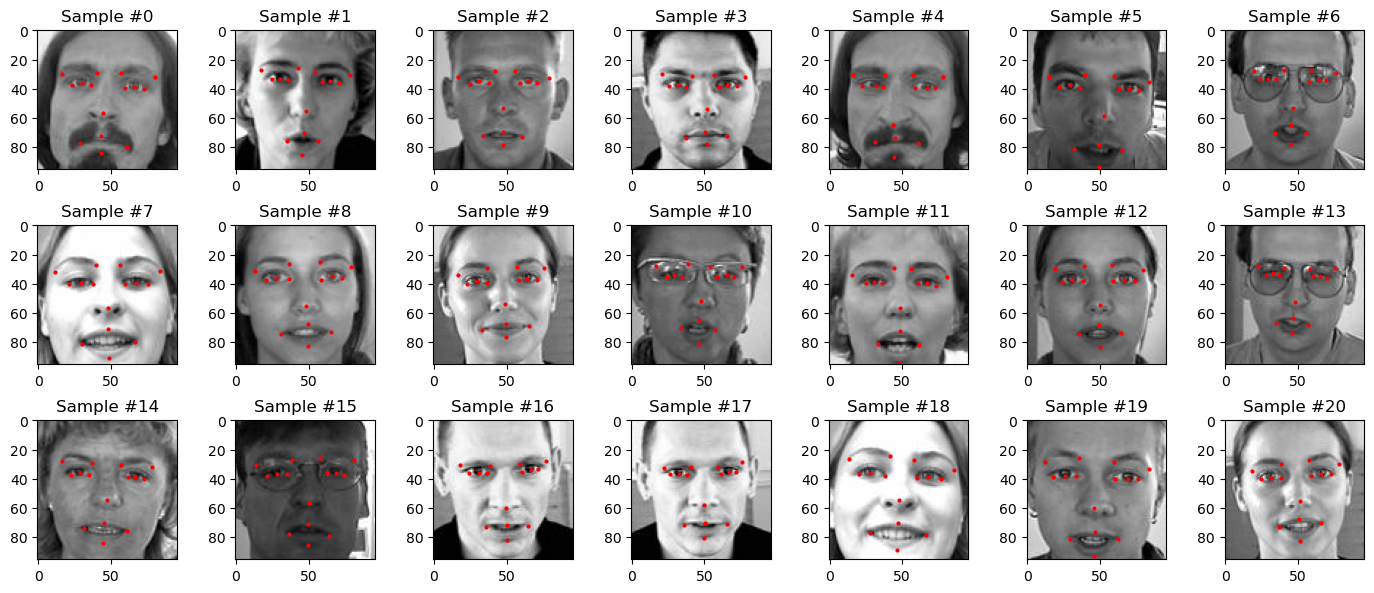

In [57]:
path = r"\Users\noble\Downloads\fall 23\ECS 171\Project\Facial Keypoint Detection Kaggle Files\images\train_images"
images = load_images(path)
show_keypoints(images[:21], train_data.values[:21])

x_train = np.array(images).reshape(-1, 96, 96, 1).astype('float64')
y_train = train_data.values.astype('float64')

# Making the Model

In [58]:
# With ResNet we don't have to worry about the vanishing gradient
# See more about skip connections 
# Define the rest of your model
resnet_model = tf.keras.models.Sequential()

# Add a Conv2D layer to match the input shape of the pre-trained ResNet50
resnet_model.add(Conv2D(3, (1, 1), padding='same', input_shape=(96, 96, 1)))
resnet_model.add(LeakyReLU(alpha=0.1))

# Add the pre-trained ResNet50 model with weights from ImageNet
pretrained_model = ResNet50(input_shape=(96, 96, 3), include_top=False, weights='imagenet')
pretrained_model.trainable = True
resnet_model.add(pretrained_model)

# Add a GlobalAveragePooling2D layer to reduce spatial dimensions
resnet_model.add(GlobalAveragePooling2D())

# Add a Dropout layer to prevent overfitting
resnet_model.add(Dropout(0.1))

# Add a Dense layer with 30 output nodes for facial keypoints
resnet_model.add(Dense(30))

# Display the model summary
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 96, 96, 3)         6         
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 96, 96, 3)         0         
                                                                 
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 30)                61470     
                                                      

In [59]:
# Early stopping to prevent overfitting
# Monitors training loss
early_stopping = EarlyStopping(monitor='loss', patience=30, mode='min', baseline=None)

# Reduce learning rate for improving convergence
# Dynamically adjust learning rate
reduce_LR = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=5, min_lr=1e-15, mode='min', verbose=1)

resnet_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'acc'])

# Training the Model

In [60]:
history = resnet_model.fit(x_train, y_train, validation_split=0.2, epochs=10, callbacks=[early_stopping, reduce_LR], batch_size=32)
print(history.history)

Epoch 1/10
177/177 [==============================] - 321s 2s/step - loss: 137.0886 - mae: 4.9328 - acc: 0.5148 - val_loss: 30.1277 - val_mae: 4.6924 - val_acc: 0.4957 - lr: 0.0010
Epoch 2/10
177/177 [==============================] - 286s 2s/step - loss: 6.5842 - mae: 1.6578 - acc: 0.7049 - val_loss: 67.5117 - val_mae: 7.3408 - val_acc: 0.7305 - lr: 0.0010
Epoch 3/10
177/177 [==============================] - 284s 2s/step - loss: 5.1267 - mae: 1.5029 - acc: 0.7583 - val_loss: 36.5649 - val_mae: 5.1895 - val_acc: 0.7135 - lr: 0.0010
Epoch 4/10
177/177 [==============================] - 285s 2s/step - loss: 4.1458 - mae: 1.3565 - acc: 0.7877 - val_loss: 48.2392 - val_mae: 6.1589 - val_acc: 0.7624 - lr: 0.0010
Epoch 5/10
177/177 [==============================] - 278s 2s/step - loss: 3.6795 - mae: 1.2844 - acc: 0.8048 - val_loss: 27.3299 - val_mae: 4.5391 - val_acc: 0.7468 - lr: 0.0010
Epoch 6/10
177/177 [==============================] - 277s 2s/step - loss: 3.5509 - mae: 1.2472 - acc: 

In [61]:
import pickle

resnet_model.save("FKD_KB1V1_E_Result-Model-ResNet50.h5")
with open('FKD_KB1V1_E_Result-History-ResNet50.pkl', 'wb') as f:
    pickle.dump(history.history, f)

c:\Users\noble\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Model Result Analysis

dict_keys(['loss', 'mae', 'acc', 'val_loss', 'val_mae', 'val_acc', 'lr'])


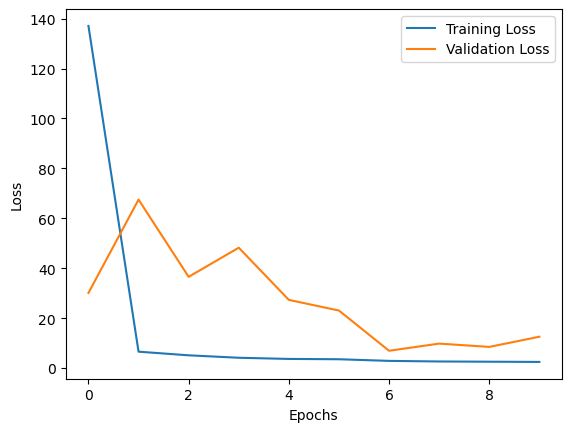

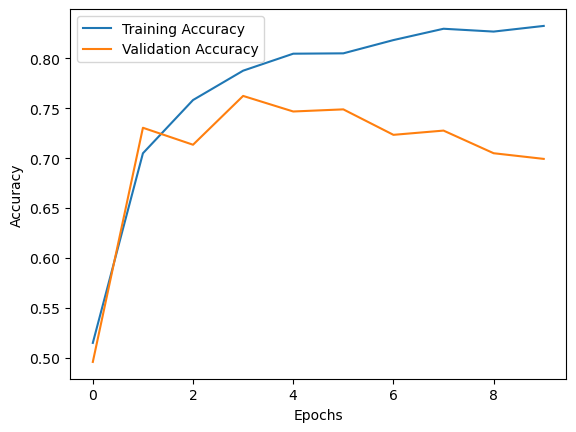

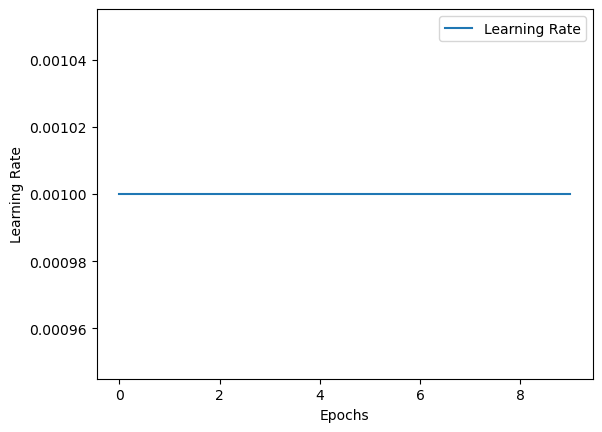

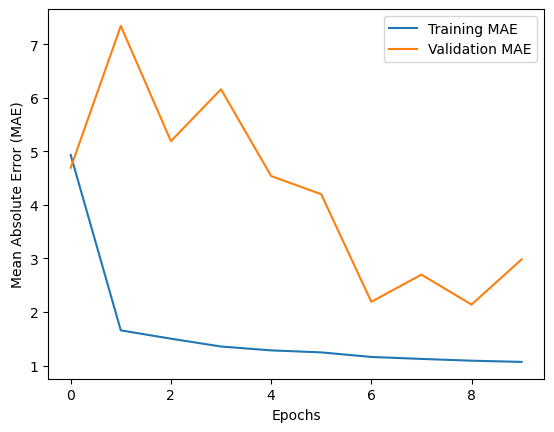

In [62]:
print(history.history.keys())

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot learning rate
plt.plot(history.history['lr'], label='Learning Rate')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.legend()
plt.show()

# Plot mean squared error
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()
plt.show()

# Predicting the Test Images

56/56 [==============================] - 23s 384ms/step
[[61.35931015 35.41901398 27.32217407 ... 64.55212402 44.4307518
  76.89730835]
 [64.17105865 34.85654449 25.71132469 ... 68.03413391 45.43730545
  78.9952774 ]
 [61.54837418 34.33479691 28.7870903  ... 67.55532074 45.8030014
  78.57764435]
 ...
 [61.36577988 38.40981293 29.82631683 ... 67.8901062  43.07256699
  70.12425232]
 [59.3343811  34.66107941 28.96372795 ... 67.90647888 42.17086029
  68.81105042]
 [62.46038055 37.66004562 29.95179367 ... 67.8368988  43.76630402
  73.4967804 ]]


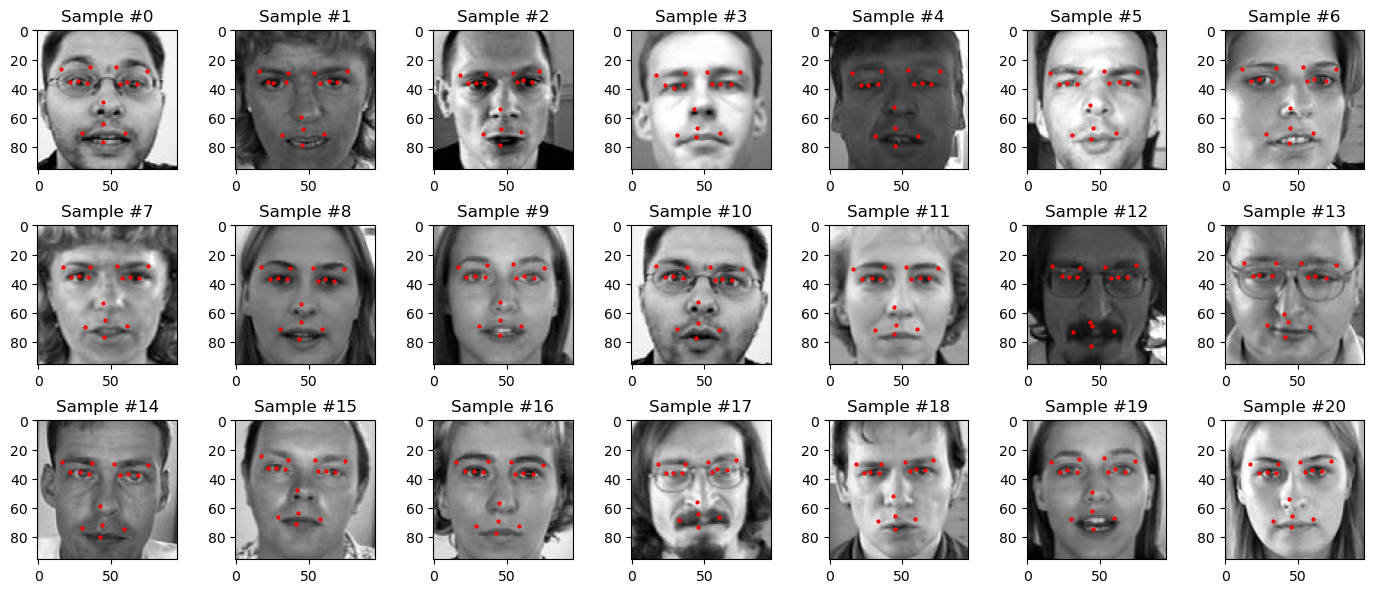

In [63]:
path = r"\Users\noble\Downloads\fall 23\ECS 171\Project\Facial Keypoint Detection Kaggle Files\images\test_images"
test_img = load_images(path)

test_img_array = np.stack(test_img, axis=0)  # Stack the list of images
x_test = test_img_array.reshape(-1, 96, 96, 1).astype('float64')
y_test = resnet_model.predict(x_test).astype('float64')
print(y_test)
show_keypoints(x_test[:21], y_test[:21])